In [74]:
%matplotlib inline
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import seaborn as sns
import math 
from scipy.stats import norm
from scipy.special import boxcox, inv_boxcox
from scipy.stats import gaussian_kde
import numpy as np
from scipy.stats import gumbel_l

In [98]:
# This code chunk is used to read data and clean and process data.

global df
global crypto_month,crypto
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('./Documents/all_currencies.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df["pct_change"] = df["Close"].pct_change().fillna(0)


In [76]:
#Setting a fixed format for displaying any plot

colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.set(rc={"figure.figsize": (10,5), "axes.titlesize" : 18, "axes.labelsize" : 12, 
"xtick.labelsize" : 14, "ytick.labelsize" : 14 })

In [77]:
"""
Used this initially to check if we need to perform BOX-COX: Seasonal decomposition helps us to understand the 
seasonal behavior and helps us understand if we need more transformation, it was almost always the case that BOX-COX 
was necessary so commented and dint use it.
"""
#def dickey_fuller():
#    #SEASONAL DECOMPOSITION
#    seasonal_decompose(crypto_month.Close, model='additive').plot()
#    print("Dickey–Fuller test for seasonal decomposition:",adfuller(crypto_month.Close)[1],2)
    

## Cryptocurrency Analysis and Monte Carlo Forecasting

### step 1: choose_currency()
###### This function is used to index the dataframe wrt to the crypto which is passed and then it can be resampled by D-Day, W-Week. As for crypto data, since it still doesnt have massive data its easier to have a detailed look by resampling it through Days.

### step 2: normalisation()
###### This function first uses a box-cox transformation to transform the time series into normal distribution, then we fit this data into a normal distribution funtion and then display a plot to understand the after-before effect of the box-cox and normal fit.

### step 3: monte_Carlo()
###### This function simulates the monte carlo scenerio for 1000 iterations, the parameters tuple is used to calculate the daily volitality and daily drift, later the price is calculated by using GBM, furthermore the data is then converted back again using inverse box-cox. All 1000 simulated scenerios are plotted for visual understanding
    
### step 4: most_likely_price()
##### This function is used to calculate the most likely price for the next year for the selected crypto, The function uses the Guassian Kernel desnity function to fit the data and then uses the probabilty density function to get the most likely price, it also shows a visual represention of KDE and Likely vs Current 


In [129]:
def choose_curreny(crypto):
    """
    input: crpto ---> String
    returns: crypto_month -----> DataFrame, crypto ----> String
    
    This function is used to index the dataframe wrt to the crypto which is passed and then it can be resampled 
    by D-Day, W-Week. As for crypto data, since it still doesnt have massive data its easier to have a detailed look
    by resampling it through Days.
    """
    
    c = df[df["Symbol"] == crypto]
    crypto_month = c[c.index.year > 2016].resample('D').mean()
    return crypto_month,crypto

In [130]:
crypto_month,crypto = choose_curreny("LTC")

In [127]:
def normalisation():
    """
    This function first uses a box-cox transformation to transform the time series into normal distribution,
    then we fit this data into a normal distribution funtion and then display a plot to understand the after-before
    effect of the box-cox and normal fit.
    
    returns: paramaters --> where parameters[0] = mean and parameters[1] = Sd of the fitted normal distrubition
    """
    
    #Applying BOX-COX Transformation to approximate into normal distribution
    crypto_month['close_box']= stats.boxcox(crypto_month.Close,2.5)
    crypto_month["pct change"] = (crypto_month.close_box.pct_change()+1).fillna(1)
    
    #Generating the mean and sd of the normal fit
    parameters = norm.fit(crypto_month['pct change'].fillna(1)-1)
    x = np.linspace(min(crypto_month["pct change"]-1), max(crypto_month["pct change"]-1), 100)

    # Generate the pdf (fitted distribution)
    fitted_pdf = norm.pdf(x,loc = parameters[0],scale = parameters[1])
    
    # Generate the pdf (normal distribution non fitted)
    normal_pdf = norm.pdf(x)
    
    #Generating the Plot
    plt.plot(x,fitted_pdf,"red",label="Fitted normal dist",linestyle="dashed", linewidth=2)
    plt.plot(x,normal_pdf,"blue",label="Normal dist", linewidth=2)
    plt.hist(crypto_month["pct change"] - 1,normed=1,color="b",alpha=.3, bins=200, label='Daily returns') 
    plt.title(crypto+" returns and normal fitting")
    plt.legend()
    plt.show()
    
    return parameters

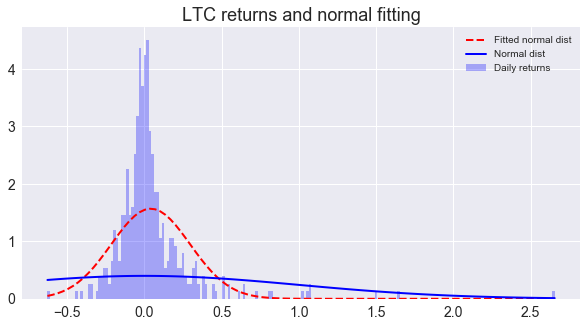

In [131]:
parameters = normalisation()

In [126]:
def monte_carlo(parameters):
    """
    input: parameters ---> tuple
    returns: inv_box_cox --> DataFrame
    
    This function simulates the monte carlo scenerio for 1000 iterations, the parameters tuple is used to calculate
    the daily volitality and daily drift, later the price is calculated by using GBM, furthermore the data is then
    converted back again using inverse box-cox. All 1000 simulated scenerios are plotted for visual understanding
    
    """
    
    #Calculating essential parameter for further forcasting
    crypto_month["pct change"] = (crypto_month.close_box.pct_change())
    daily_volatility = parameters[1]
    daily_drift = parameters[0]
    mean_drift = daily_drift - 0.5 * (daily_volatility)**2
    last_price = crypto_month["close_box"][-1]

    #Monte Carlo simulation 
    sim_df=pd.DataFrame()
    for x in range(1000):
        count = 0
        price_series = []
        last_price = crypto_month['close_box'][-1]
        for y in range(365):
            log_return = mean_drift + (daily_volatility * np.random.normal(0, 1))
            price = last_price * (math.e ** log_return)
            price_series.append(price)
            last_price = price
            count += 1
        sim_df[x] = price_series
    
    #Getting back to origional data using Inverse BOX-COX
    inv_box_cox=inv_boxcox(sim_df,2.5)
    
    #Plotting all 1000 iterations of Monte Carlo scenerio of forcasted price series
    plt.plot(inv_box_cox)
    plt.yscale('log')
    plt.xlabel('Days', size=20)
    plt.ylabel('Price ($) (log scale)', size=20)
    plt.title('Monte Carlo Simulation of '+crypto+' for next year', size=20)
    plt.show()
    
    return inv_box_cox

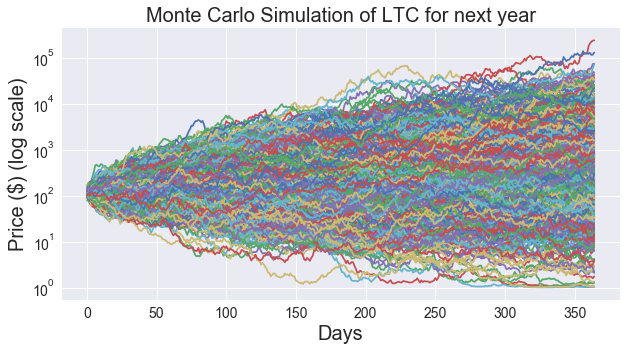

In [132]:
inv_box_cox = monte_carlo(parameters)

In [125]:
def most_likely_price(inv_box_cox):
    """
    input: inv_box_cox ---> DataFrame
    returns: nothing
    
    This function is used to calculate the most likely price for the next year for the selected crypto, 
    The function uses the Guassian Kernel desnity function to fit the data and then uses the probabilty density 
    function to get the most likely price, it also shows a visual represention of KDE and Likely vs Current 
    """
    
    #Finding out all the possible likely prices of all the 1000 simulations
    possible_prices = pd.DataFrame(inv_box_cox)
    possible_prices = possible_prices.iloc[-1,:]
    
    #Plotting the histogram for likely possible prices of the simulations
    fig, ax = plt.subplots()
    plt.hist(np.log(possible_prices),bins=25,density=True)
    xticks = plt.xticks()
    ticks = np.linspace(min(np.log(possible_prices)), max(np.log(possible_prices)), 10)
    plt.xticks(ticks, [str(int(np.exp(tick))) for tick in ticks]);

    #Using the Gaussian KDE(Kernel density estimation) and then using pdf function to get the most likely price
    kde = gaussian_kde(np.log(possible_prices))
    x = np.linspace(min(np.log(possible_prices)), max(np.log(possible_prices)), 25)
    ax.plot(x, kde.pdf(x), linewidth=3, c='orange', alpha=1, label='KDE density function')

   
    #Displaying Most likely Price for next year
    most_likely_price = np.exp(x[np.argmax(kde.pdf(x))])
    ax.vlines(np.log(most_likely_price), 0, kde.pdf(np.log(most_likely_price)), color='w')
    ax.annotate('Most likely price: ${}'.format(int(round(most_likely_price))), 
                xy=(np.log(most_likely_price), kde.pdf(np.log(most_likely_price))), 
                xytext=(11, 0.2),
                arrowprops=dict(facecolor='black', shrink=0.1),
                size=19)
    
    
    #Displaying Current price on the Plot
    current_price = crypto_month.Close[-1]
    ax.vlines(np.log(current_price), 0, kde.pdf(np.log(current_price)), color='w')
    ax.annotate('Current price: ${}'.format(int(round(current_price))), 
                xy=(np.log(current_price), 0), 
                xytext=(10, 0.1),
                arrowprops=dict(facecolor='black', shrink=0.0),
                size=14, 
                color='black')

    
    
    plt.xlabel('Price ($)', size=20)
    plt.ylabel('Density', size=20)
    plt.title('Distribution of '+crypto+' simulated prices for next year', size=20)
    plt.show()
    
    print("The 80% confidence interval is:" + str(possible_prices.quantile(.2)), str(possible_prices.quantile(.8)))

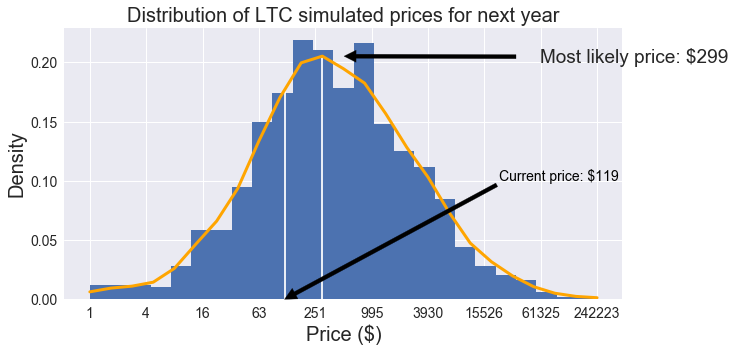

The 80% confidence interval is:80.32797257606842 1922.3313362299077


In [133]:
possible_prices = most_likely_price(inv_box_cox)

## Detection of Blackswans in Cryptocurrency Space

In [137]:
def blackswans():
    col = ['Date', 'Return','crypto']
    dfblack = pd.DataFrame(columns=col)
    
    
    for i in df["Symbol"].unique():
        rmin = df[df["Symbol"]==i]["pct_change"].sort_values()[0]
        tmin = df[df["Symbol"]==i]["pct_change"].sort_values().index[0]
        crypto = i
        dfblack.loc[len(dfblack)]=[tmin, rmin,crypto]  # add new row to dfblack
    
    
    locG, scaleG = gumbel_l.fit(dfblack["Return"]+1)  # location, scale parameters
 
    dx = 0.000001
    x = [dx*i for i in range(-int(1/dx), int(1/dx)+1)]
    x2 = x.copy()

    plt.figure(num=3, figsize=(9, 4))
    plt.hist(dfblack["Return"], bins=30, normed=True, color="grey", 
                 label="Crypto Data")
    pdf1 = gumbel_l.pdf(x2, loc=locG, scale=scaleG)
    y = pdf1.copy()
    plt.plot(x2, y, 'r', linewidth=1, label="Gumbel PDF fit")
    plt.xlim([-1, 0])
    plt.xlabel('Daily loss [%]', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.legend(loc=1)
    
    
    # re-fit Gumbel (to remain politically correct in-sample ;)
    locG, scaleG = gumbel_l.fit(dfblack["Return"])


    # extract black swans from EREs data set
    dfb = dfblack[dfblack["Return"] < locG+scaleG ]  
    dfb = dfb.set_index("Date")
    dfb = dfb.sort_index()
    dfb0 = dfb.copy()

    plt.figure(figsize=(13, 6))
    plt.plot(dfb["Return"]*100, '.r')
    plt.xlabel('Time Interval [%s to %s]' % (dfb.index[0], dfb.index[-1]), 
                   fontsize=14)
    plt.ylabel('Black Swan Magnitude [%]', fontsize=14)
    plt.title('Time Distribution of Black Swans of %g Crypto (L < %.1f%%)' % 
                  (len(dfb), (locG+scaleG)*100), fontsize=14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.ylim([-100, 0])
    plt.xlim([dt.date(2013,1,1), dt.date(2017, 12, 1)])
    
    print(locG, scaleG, locG+scaleG)
 
    Pr_bs = gumbel_l.cdf(locG+scaleG, loc=locG, scale=scaleG)
    print(Pr_bs)




-0.6503743243087613 0.3891822560366457 -0.2611920682721156
0.9340119641546875


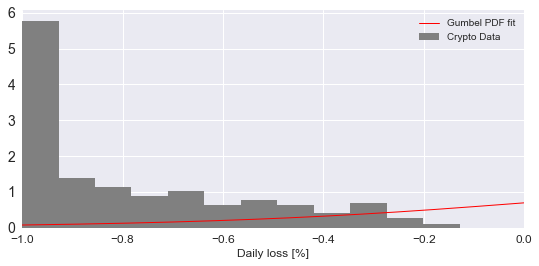

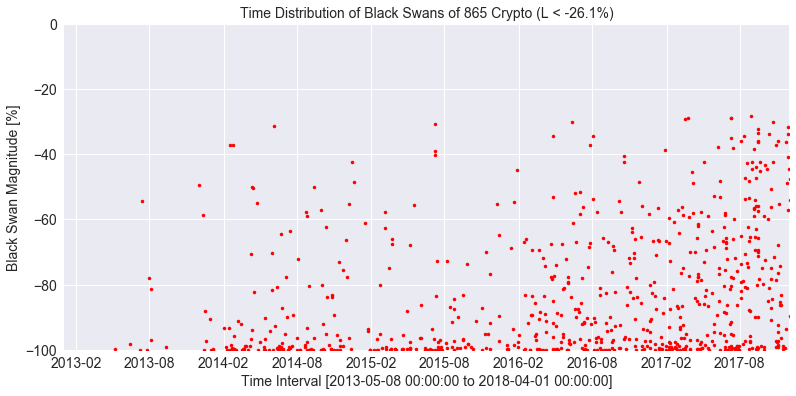

In [138]:
blackswans()